In [1]:
import pandas as pd
import akshare as ak
from scipy.stats import norm
from scipy.optimize import minimize
import numpy as np
from math import log
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

# 整理模型所需要数据

In [2]:
def process(rate_name,fin_name):   
    mdata = pd.read_csv(rate_name)
    #将中债隐含评级数据换为数字
    mdata.loc[(mdata["F2_0003"]== 'AAA+'),"评级"] = 10
    mdata.loc[(mdata["F2_0003"]== 'AAA')  ,"评级"] = 9
    mdata.loc[(mdata["F2_0003"]== 'AA+')|(mdata["F2_0003"]== 'AAA-')  ,"评级"] = 8
    mdata.loc[(mdata["F2_0003"]== 'AA')|(mdata["F2_0003"]== 'AA(2)'),"评级"] = 7
    mdata.loc[mdata["F2_0003"]== 'AA-',"评级"] = 6
    mdata.loc[(mdata["F2_0003"]== 'A+')  ,"评级"] = 5
    mdata.loc[(mdata["F2_0003"]== 'A'),"评级"] = 4
    mdata.loc[(mdata["F2_0003"]== 'A-'),"评级"] = 3
    mdata.loc[(mdata["F2_0003"]== 'BBB+') |( mdata["F2_0003"]== 'BBB')|( mdata["F2_0003"]== 'BBB-') ,"评级"] = 2
    mdata.loc[(mdata["F2_0003"]== 'BB') |( mdata["F2_0003"]== 'B') ,"评级"] = 1
    mdata.loc[(mdata["F2_0003"]== 'CCC') |( mdata["F2_0003"]== 'CC')|( mdata["F2_0003"]== 'C') ,"评级"] = 0
    #比较年初年末的中债数据
    first_date = min(mdata["F1_2014"])
    first = mdata.loc[mdata["F1_2014"] ==first_date ]
    final_date = max(mdata["F1_2014"])
    final = mdata.loc[mdata["F1_2014"] ==final_date ]
    #关联年末年初的数据表
    data = pd.merge(first,final,on = "OB_OBJECT_NAME_1090")
    #如果数据下降则下降等于1
    data.loc[(data['评级_x']> data['评级_y']),"下降"] = 1
    fin_data = pd.read_csv(fin_name)
    #和发债主体的财务数据相关联
    data = pd.merge(bond,data,left_on  ="secu_cd",right_on = "F16_1090_x")
    data = pd.merge(fin_data,data,left_on ="corp_id",right_on = "issr_id")
    data_defualt = data.loc[data["下降"]==1]
    default_company = data_defualt["issr_id"].unique()
    company = data["issr_id"].unique()
    bond_data = pd.DataFrame()
    bond_data["ID"] = company
    bond_data.loc[bond_data["ID"].isin(default_company) == 1  ,"下降"] = 1
    bond_data["下降"] =  bond_data["下降"].fillna(0)
    bond_data = pd.merge(bond_data,fin_data,left_on = "ID",right_on = "corp_id")
    bond_data = bond_data.dropna(subset=["ebitda"])
    bond_data = bond_data.fillna(0)
    #整理要放入模型的数据
    model_data = pd.DataFrame()
    model_data["企业"] = bond_data["ID"]
    model_data["主营业务利润率"] = bond_data["biz_prof_biz_total_ncm_rt"]
    model_data["营业成本收入比"] = bond_data["biz_cost_ncm_rt"]
    model_data["总资产报酬率"] = bond_data["total_ast_rwrd_rate_ann"]
    model_data["总资产收益率"] = bond_data["total_ast_prft_rate"]
    model_data["应收账款周转率"] = bond_data["recv_acc_tr"]
    model_data["存货周转率"] = bond_data["invt_tr"]
    model_data["流动比率"] =bond_data["flow_rt"]
    model_data["速度比率"] = bond_data["qr"]
    model_data["EBITA/带息债务"] = bond_data["ebitda"]/(bond_data["st_brow"]+bond_data["lt_brow"])
    model_data["资产负债率"] = bond_data["ast_liab_rate"]
    model_data["短期债务/总债务"] = bond_data["flow_liab_tot"]/bond_data["liab_tot"]
    model_data["货币资金/总债务"] = bond_data["crrc_fund"]/bond_data["liab_tot"]
    model_data["货币资金/短期债务"] = bond_data["crrc_fund"]/bond_data["flow_liab_tot"]
    model_data["营业收入增长率"] = bond_data["biz_ncm_yoy_incr"]
    model_data["违约"] = bond_data["下降"]
    model_data =model_data.replace([np.inf, -np.inf], np.nan) 
    model_data = model_data.dropna()
    return model_data

In [3]:
bond = pd.read_csv("new bond.csv")
data_2015 = process("2015 中债.csv","2015 data.csv")
data_2018 = process("2018 中债.csv","2018 data.csv")
data_2019 = process("2019 中债.csv","2019 data.csv")
data_2020 = process("2020 中债.csv","2020 data.csv")
model_data = pd.concat([data_2015, data_2018,data_2019,data_2020])


# 使用Linear Reg 进行预测

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
y = model_data["违约"]
X = model_data.drop(columns=['企业', '违约'])



X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.7, test_size=0.3, random_state=188)
clf = LogisticRegression( max_iter=3000)

# 使用训练数据来学习（拟合），不需要返回值，训练的结果都在对象内部变量中
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
lr_train = clf.score(X_train,y_train)
lr_train_pre = precision_score(y_train, y_pred)
lr_train_recall= recall_score(y_train, y_pred)

y_pred = clf.predict(X_test)
lr_test = clf.score(X_test,y_test)
lr_test_pre = precision_score(y_test, y_pred)
lr_test_recall= recall_score(y_test, y_pred)

# 使用XG boost 进行预测，绘制重要性表

In [17]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV

other_params = {"scale_pos_weight" :5,'max_depth': 1, 'min_child_weight': 6, 'max_depth': 1, 'min_child_weight': 6, 'n_estimators': 600,'colsample_bytree': 0.9, 'gamma': 0.01, 'subsample': 0.6,'learning_rate': 0.001}
xgboost_model = xgb.XGBClassifier(**other_params)

param_grid = {'learning_rate': [1e-5,1e-4,1e-3,1e-2,1e-1]}


kflod = StratifiedKFold(n_splits=10, shuffle = True,random_state=7)#将训练/测试数据集划分10个互斥子集，
 
grid_search = GridSearchCV(xgboost_model,param_grid,n_jobs = -1,cv = 3,scoring = "f1")
grid_result = grid_search.fit(X_train, y_train)

means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean,param in zip(means,params):
    print("%f  with:   %r" % (mean,param))


0.360844  with:   {'learning_rate': 1e-05}
0.360844  with:   {'learning_rate': 0.0001}
0.363020  with:   {'learning_rate': 0.001}
0.348172  with:   {'learning_rate': 0.01}
0.333925  with:   {'learning_rate': 0.1}


In [16]:

print('最优参数组合:', grid_result.best_params_, '最好得分:', grid_result.best_score_)


最优参数组合: {'colsample_bytree': 0.9, 'gamma': 0.01, 'subsample': 0.6} 最好得分: 0.3240306315869285


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

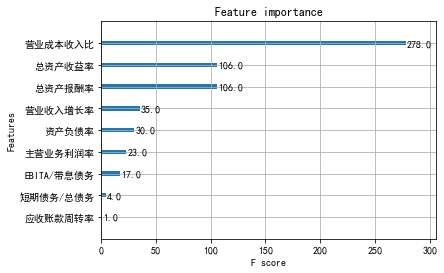

In [18]:
other_params = {"scale_pos_weight" :5,'max_depth': 1, 'min_child_weight': 6, 'max_depth': 1, 'min_child_weight': 6, 'n_estimators': 600,'colsample_bytree': 0.9, 'gamma': 0.01, 'subsample': 0.6,'learning_rate': 0.001}
xgboost_model = xgb.XGBClassifier(**other_params).fit(X_train,y_train)





#plot_importance(xgboost_model)
pred = xgboost_model.predict(X_train)
xgb_train = xgboost_model.score(X_train,y_train)
xgb_train_pre = precision_score(y_train, pred)
xgb_train_recall = recall_score(y_train, pred)

pred = xgboost_model.predict(X_test)
xgb_test = xgboost_model.score(X_test,y_test)
xgb_test_pre = precision_score(y_test, pred)
xgb_test_recall =  recall_score(y_test, pred)
plot_importance(xgboost_model)

In [24]:
xgb_test_recall

0.559322033898305

In [92]:
file= pd.DataFrame()

file["truth"] = y_test
file["pred"] = pred
file.to_excel("test_output.xlsx")

# 绘制并比较预测结果

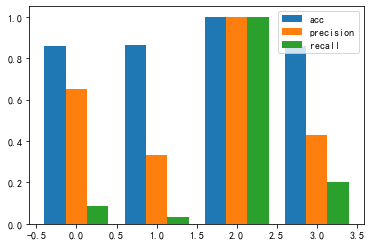

In [6]:

import matplotlib.pyplot as plt
size = 4
x = np.arange(size)
acc = [lr_train,lr_test,xgb_train,xgb_test]
precision = [lr_train_pre,lr_test_pre,xgb_train_pre,xgb_test_pre]
recall = [lr_train_recall,lr_test_recall,xgb_train_recall,xgb_test_recall]



total_width, n = 0.8, 3
width = total_width / n
x = x - (total_width - width) / 2

plt.bar(x, acc,  width=width, label='acc')
plt.bar(x + width, precision, width=width, label='precision')
plt.bar(x + 2 * width, recall, width=width, label='recall')
plt.legend()
plt.show()

In [7]:
recall

[0.08441558441558442, 0.03389830508474576, 1.0, 0.2033898305084746]

# 违约距离计算（暂时没用上）

In [8]:
import akshare as ak
for i in range(0,leng):
    try:    
        stock_zh_a_daily_qfq_df = ak.stock_zh_a_daily(symbol=code[i], start_date="20171231", end_date="20190101", adjust="qfq")
        stock_zh_a_daily_qfq_df["value"] = stock_zh_a_daily_qfq_df["outstanding_share"]*stock_zh_a_daily_qfq_df["close"]
        stock_zh_a_daily_qfq_df["next"] = stock_zh_a_daily_qfq_df["close"].shift(1)
        stock_zh_a_daily_qfq_df.dropna(inplace = True)
        n = len(stock_zh_a_daily_qfq_df["next"])
        rf = 1.5
        stock_zh_a_daily_qfq_df["change"] =(stock_zh_a_daily_qfq_df["close"]/stock_zh_a_daily_qfq_df["next"]-1)*100
        stock_zh_a_daily_qfq_df["change"] = (stock_zh_a_daily_qfq_df["change"]).apply(np.log1p) 
        std = stock_zh_a_daily_qfq_df["change"].std()
        mean = stock_zh_a_daily_qfq_df["close"].mean()
        sharp = (mean - rf)/std
        V_equity = mean*total_shar[i]
        default_point = (lib[i]-lt_lib[i])*1.045
        rf_rate = 0.015
        sigma_equity = std 
        T = 1
        # One dimension estimation
        def equation(x):
            d1 = (np.log(x[0]/default_point) + (rf_rate+x[1]**2/2)*T)/(x[1] * np.sqrt(T))
            d2 = d1 - x[1] * np.sqrt(T)
            res1 = x[0] * norm.cdf(d1) - np.exp(-rf_rate*T) * default_point * norm.cdf(d2) - V_equity
            res2 = x[0] * norm.cdf(d1) * x[1] - V_equity * sigma_equity
            return(res1**2+res2**2)
        result = minimize(equation,[V_equity,sigma_equity])
        V_asset = list(result["x"])[0]
        sigma_asset = list(result["x"])[1]
        DD = (V_asset-default_point)/(sigma_asset*V_asset)
        list_D.append(DD)
        sharp_list.append(sharp)
        record_code.append(code[i])
    except Exception as e:
        pass
    continue
DD

NameError: name 'leng' is not defined